In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss
import fastai.callbacks.hooks
import json

In [3]:
path = Path("")

In [4]:
jsIn = json.load((path/"train.json").open())

In [5]:
class ImageWithAngle(Image):
    def __init__(self,px,angle):
        super().__init__(px)
        self.angle = angle
        self.na = 0.0
        if self.angle == "na":
            self.angle = 0.0
            self.na = 1.0
        
    def clone(self):
        return self.__class__(self.px.clone(),self.angle)
        
    @property
    def data(self)->TensorImage:
        return self.px, torch.tensor(self.angle)

In [6]:
class JSONImageItemList(ImageItemList):
    def get(self, i):
        img = self.items[i]
        angle = img["inc_angle"]
        a,b = torch.tensor(img["band_1"]), torch.tensor(img["band_2"])
        a = a / a.min()
        b = b / b.min()
        img = torch.stack([a,b,(a+b)/2],dim=0).view(3,75,75)
        return Image(img)
        
    
    @classmethod
    def from_json(cls,js,**kwargs):
        return cls(js,**kwargs)

In [7]:
src = (JSONImageItemList.from_json(jsIn)
       .random_split_by_pct(0.2)
       #.label_from_func(lambda item: float(item["is_iceberg"])))
       .label_from_func(lambda item: item["is_iceberg"] == 1))

In [8]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = src.transform(tfms,size=75).databunch(bs=16,num_workers=0)#.normalize(imagenet_stats)

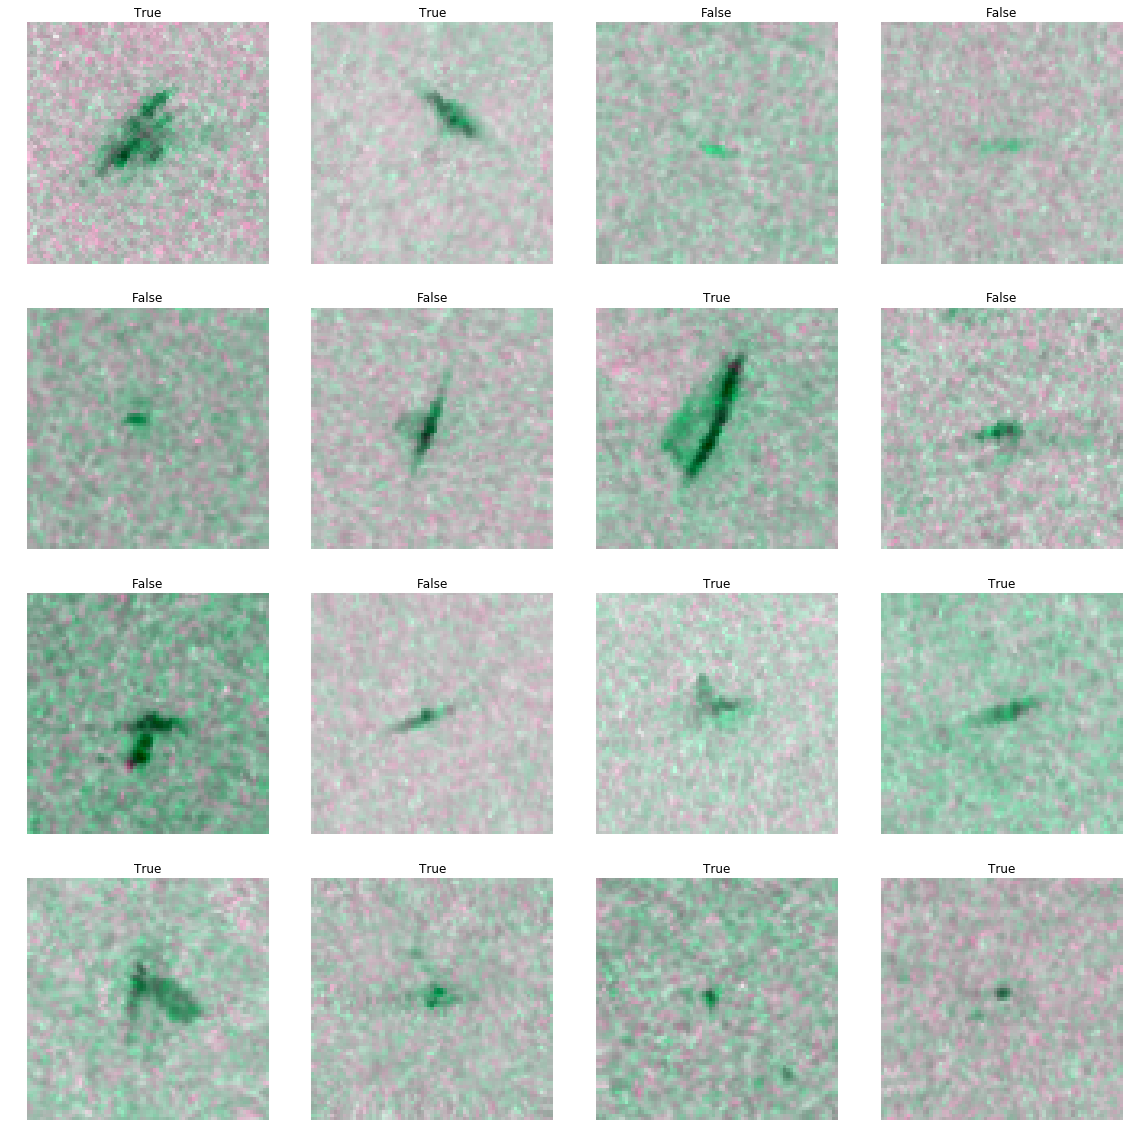

In [9]:
data.show_batch()

In [33]:
class Gate(torch.nn.Module):
    """
    Attention Gate. Weights Attention output by its importance.
    """

    def __init__(self, in_ch, ngates=1, gate_depth=1):
        """ Constructor
        Args:
            in_ch: number of input channels.
        """
        super(Gate, self).__init__()
        if gate_depth == 1:
            self.gates = torch.nn.Linear(in_ch, ngates, bias=False)
        else:
            self.gates = torch.nn.Linear(in_ch // 2, ngates, bias=False)
            self.pre_gates = torch.nn.Linear(in_ch, in_ch // 2, bias=False)
            torch.nn.init.kaiming_normal_(self.pre_gates.weight.data)
            self.pre_bn = torch.nn.BatchNorm1d(in_ch // 2)

        torch.nn.init.kaiming_normal_(self.gates.weight.data)
        self.bn = torch.nn.BatchNorm1d(ngates)

        self.gate_depth = gate_depth

    def forward(self, x):
        """ Pytorch forward function
        Args:
            x: input Variable
        Returns: gate value (Variable)
        """
        if self.gate_depth == 1:
            return torch.tanh(self.bn(self.gates(x)))
        else:
            return torch.tanh(self.bn(self.gates(F.relu(self.pre_bn(self.pre_gates(x))))))


class AttentionHead(torch.nn.Module):
    """ Attention Heads
    Attentds a given feature map. Provides inter-mask regularization.
    """

    def __init__(self, in_ch, nheads=1):
        """ Constructor
        Args:
            in_ch: input feature map channels
            nheads: number of attention masks
        """
        super(AttentionHead, self).__init__()
        self.nheads = nheads
        self.conv = torch.nn.Conv2d(in_ch, nheads, kernel_size=3, padding=1, bias=False)
        torch.nn.init.kaiming_normal_(self.conv.weight.data)
        self.register_buffer("diag",
                             torch.from_numpy(
                                 1 - np.eye(self.nheads, self.nheads).reshape(1, self.nheads, self.nheads)).float())

    def reg_loss(self):
        """ Regularization Loss
        Returns: a Variable with the inter-head regularization loss.
        """
        mask2loss = self.att_mask.view(self.att_mask.size(0), self.nheads, -1)
        reg_loss = torch.bmm(mask2loss, mask2loss.transpose(1, 2)) * torch.autograd.Variable(self.diag,
                                                                                             requires_grad=False)
        return (reg_loss.view(-1) ** 2).mean()

    def forward(self, x):
        """ Pytorch Forward
        Args:
            x: input feature map
        Returns: the multiple attended feature maps
        """
        b, c, h, w = x.size()
        att_mask = F.softmax(self.conv(x).view(b, self.nheads, w * h), 2).view(b, self.nheads, h, w)
        self.att_mask = F.avg_pool2d(att_mask, 2, 2)
        return att_mask


class OutHead(torch.nn.Module):
    """ Attention Heads
    Attentds a given feature map. Provides inter-mask regularization.
    """

    def __init__(self, in_ch, out_ch):
        """ Constructor
        Args:
            in_ch: input feature map channels
            nheads: number of attention masks
        """
        super(OutHead, self).__init__()
        self.conv = torch.nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False)
        torch.nn.init.kaiming_normal_(self.conv.weight.data)

    def forward(self, x):
        """ Pytorch Forward
        Args:
            x: input feature map
        Returns: the multiple attended feature maps
        """
        return self.conv(x)


class AttentionModule(torch.nn.Module):
    """ Attention Module
    Applies different attention masks with the Attention Heads and ouputs classification hypotheses.
    """

    def __init__(self, in_ch, nlabels, nheads=1, reg_w=0.0, self_attention=True):
        """ Constructor
        Args:
            in_ch: number of input feature map channels
            h: input feature map height
            w: input feature map width
            nlabels: number of output classes
            nheads: number of attention heads
            has_gates: whether to use gating (recommended)
            reg_w: inter-mask regularization weight
        """
        super(AttentionModule, self).__init__()
        self.in_ch = in_ch
        self.nlabels = nlabels
        self.nheads = nheads
        self.reg_w = reg_w
        self.self_attention = self_attention

        self.att_head = AttentionHead(in_ch, nheads)
        self.out_head = OutHead(in_ch, nlabels * nheads)
        if self.self_attention:
            self.score = OutHead(in_ch, nheads)

    def reg_loss(self):
        """ Regularization loss
        Returns: A Variable with the inter-mask regularization loss for this  Attention Module.
        """
        return self.att_head.reg_loss() * self.reg_w

    def forward(self, x):
        """ Pytorch Forward
        Args:
            x: input feature map.
        Returns: tuple with predictions and gates. Gets are set to None if disabled.
        """
        b, c, h, w = x.size()
        att_mask = self.att_head(x).view(b, self.nheads, 1, h * w)
        output = (self.out_head(x).view(b, self.nheads, self.nlabels, h * w) * att_mask).sum(3)
        if self.self_attention:
            scores = self.score(x).view(b, self.nheads, 1, h * w)
            scores = (scores * att_mask).sum(3)
            scores = F.softmax(torch.tanh(scores), 1)
            return (output * scores).sum(1, keepdim=True)
        else:
            return output

    @staticmethod
    def aggregate(outputs, gates, function='softmax'):
        """ Generates the final output after aggregating all the attention modules.
        Args:
            last_output: network output logits
            last_gate: gate for the network output
        Returns: final network prediction
        """
        outputs = torch.cat(outputs, 1)
        outputs = F.log_softmax(outputs, dim=2)
        if gates is not None:
            if function == 'softmax':
                gates = F.softmax(gates, 1).view(gates.size(0), -1, 1)
                ret = (outputs * gates).sum(1)
            else:
                gates = F.sigmoid(gates).view(gates.size(0), -1, 1)
                ret = (outputs * gates).sum(1) / (1e-6 + gates.sum(1))
        else:
            ret = outputs.mean(1)

        return ret

In [34]:
class AttentionAlexnet(nn.Module):
    def __init__(self, num_classes=1000,nheads=1,reg_w=0.0):
        super().__init__()
        self.reg_w = reg_w
        self.hero = create_body(models.alexnet,pretrained=True)
        ml = [f for i,f in enumerate(next(self.hero.children()).children()) if i in [2,5,7,9,12]]
        self.hooks = fastai.callbacks.Hooks(ml,lambda m,i,o: o,detach=False)
        
        self.attention_layers = nn.ModuleList([AttentionModule(nf,num_classes,nheads,reg_w) for nf in [64,192,384,256,256]])
        self.output_gate = Gate(256,5+1,gate_depth=1)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.classifier = create_head(256*2,num_classes)
    
    def reg_loss(self):
        """ Compute regularization loss
        Returns: the total accumulated reg loss of the network
        """
        loss = 0
        for l in self.attention_layers:
            loss += l.reg_loss()
        return loss / len(self.attention_layers)
    
    def forward(self, x):
        bs = x.shape[0]
        pt = self.hero(x)
        
        attention_outputs = [a(f) for f,a in zip(self.hooks.stored,self.attention_layers)]

        gates = self.output_gate(self.avg(pt).view(bs,-1))
        
        if self.training and self.reg_w > 0:
            reg_loss = self.reg_loss()
        else:
            reg_loss = None
        
        attention_outputs.append(self.classifier(pt).unsqueeze(1))
        ret = AttentionModule.aggregate(attention_outputs,gates,"softmax")
        
        return ret, reg_loss

In [35]:
def loss(preds,target):
    p, rl = preds
    return rl + F.nll_loss(p,target) if rl else F.nll_loss(p,target)

In [36]:
def logloss(preds,target):
    preds = preds[0]
    preds = torch.softmax(preds,dim=1)
    preds = preds.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    return torch.tensor(log_loss(target,preds))

In [37]:
def myacc(preds,target):
    return accuracy(preds[0],target)

In [43]:
learnAttn = Learner(data,AttentionAlexnet(data.train_ds.c,nheads=3,reg_w=0.001),loss_func=loss,metrics=[myacc,logloss])
learnAttn.split([learnAttn.model.hero,learnAttn.model.attention_layers[0]])

In [44]:
learnAttn.model(next(iter(data.train_dl))[0])[0].shape

torch.Size([16, 2])

In [45]:
learnAttn.freeze_to(1)

In [46]:
learnAttn.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,myacc,logloss
1,0.671830,0.612668,0.790625,0.591025
2,0.578438,0.486262,0.850000,0.418011
3,0.517511,0.427343,0.859375,0.361919
4,0.457257,0.390810,0.878125,0.314300
5,0.434318,0.373373,0.865625,0.298758
6,0.401536,0.358282,0.840625,0.303713
7,0.394862,0.365226,0.856250,0.306853
8,0.368741,0.358708,0.853125,0.285459
9,0.355019,0.336338,0.868750,0.272612
10,0.341182,0.333221,0.850000,0.282788


In [47]:
learnAttn.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,myacc,logloss
1,0.290019,0.279885,0.875000,0.237092
2,0.298328,0.280134,0.871875,0.241023
3,0.277230,0.276749,0.881250,0.236068
4,0.292897,0.290324,0.868750,0.240554
5,0.295413,0.277617,0.881250,0.236580
6,0.290922,0.279897,0.881250,0.235160
7,0.277043,0.276046,0.878125,0.234312
8,0.267348,0.280430,0.878125,0.236871
9,0.285411,0.279603,0.881250,0.234716
10,0.280920,0.279953,0.878125,0.235169
